In [34]:
from collections import deque, defaultdict
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [35]:
# Import data
df = pd.read_csv("df_merged.csv")

# Normalized reward
df["reward"] = (df["Rating"] - 1) / 4.0

# IDs
user_ids = df["UserID"].unique()
movie_ids = df["MovieID"].unique()

u2i = {u: i for i, u in enumerate(user_ids)}
m2i = {m: i for i, m in enumerate(movie_ids)}
i2m = {i: m for m, i in m2i.items()}

df["u_idx"] = df["UserID"].map(u2i).astype(int)
df["m_idx"] = df["MovieID"].map(m2i).astype(int)

n_users = len(user_ids)
n_items = len(movie_ids)

print("Users:", n_users, "Items:", n_items, "Ratings:", len(df))



Users: 6040 Items: 3706 Ratings: 1000209


In [36]:
# Dictionary for ratings
rating_dict = {
    (int(u), int(m)): float(r)
    for u, m, r in ratings[["u_idx", "m_idx", "reward"]].to_numpy()
}

# Simulate like a flux (thanks to time stamp)
events = ratings.sort_values("Timestamp")[["u_idx", "m_idx", "reward"]].to_numpy()


In [37]:
# Create matrix user x film with ratings 
R = sparse.coo_matrix(
    (ratings["reward"].values, (ratings["u_idx"].values, ratings["m_idx"].values)),
    shape=(n_users, n_items)
).tocsr()

# Create film embedding for the film
d = 30  # latent dimension
svd = TruncatedSVD(n_components=d, random_state=0)
item_factors = svd.fit_transform(R.T)
item_factors = item_factors / (np.linalg.norm(item_factors, axis=1, keepdims=True) + 1e-12)

# Use K means to partition film
K = 50
kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto")
item_cluster = kmeans.fit_predict(item_factors)
cluster_items = {c: np.where(item_cluster == c)[0] for c in range(K)}


In [38]:
class DC3MABLike:
    """
    Contextual bandit DC³MAB:
    1) Dynamicaly cluster users
    2) Partition films
    3) LinUCB at cluster level
    """

    def __init__(
        self,
        n_users: int,
        item_factors: np.ndarray,
        item_cluster: np.ndarray,
        cluster_items: dict,
        alpha: float = 0.6,
        lam: float = 1.0,
        edge_init: str = "kmeans",
        user_init_clusters: int = 50,
        split_beta: float = 1.0,
        seed: int = 0
    ):
        self.rng = np.random.default_rng(seed)
        self.n_users = int(n_users)

        self.X = np.asarray(item_factors, dtype=float)
        self.d = self.X.shape[1]

        self.item_cluster = np.asarray(item_cluster, dtype=int)
        self.cluster_items = {int(k): np.asarray(v, dtype=int) for k, v in cluster_items.items()}
        self.K = len(self.cluster_items)

        self.alpha = float(alpha)
        self.lam = float(lam)
        self.split_beta = float(split_beta)

        # Per-user LinUCB stats
        self.A = np.array([np.eye(self.d) * self.lam for _ in range(self.n_users)])
        self.b = np.zeros((self.n_users, self.d))
        self.t = np.zeros(self.n_users, dtype=int)

        # User graph, remove links when they are too far appart in film taste
        self.G = [set() for _ in range(self.n_users)]
        self.init_graph(edge_init=edge_init, user_init_clusters=user_init_clusters)

    def init_graph(self, edge_init: str, user_init_clusters: int):
        edge_init = str(edge_init).lower()
        if edge_init == "full":
            all_users = set(range(self.n_users))
            for u in range(self.n_users):
                self.G[u] = all_users - {u}
            return

        # User embedding
        user_emb = self.rng.normal(size=(self.n_users, self.d))
        km = KMeans(n_clusters=int(user_init_clusters), random_state=0, n_init="auto")
        ucl = km.fit_predict(user_emb)

        groups = defaultdict(list)
        for u, c in enumerate(ucl):
            groups[int(c)].append(int(u))

        for us in groups.values():
            s = set(us)
            for u in us:
                self.G[u] = s - {u}

    def theta_user(self, u: int) -> np.ndarray:
        Ainv = np.linalg.inv(self.A[u])
        return Ainv @ self.b[u]

    def cluster_of(self, u: int):
        seen = {u}
        q = deque([u])
        while q:
            x = q.popleft()
            for y in self.G[x]:
                if y not in seen:
                    seen.add(y)
                    q.append(y)
        return list(seen)

    def cluster_model(self, cluster_users):
        A_sum = np.zeros((self.d, self.d))
        b_sum = np.zeros(self.d)
        for v in cluster_users:
            A_sum += self.A[v]
            b_sum += self.b[v]
        Ainv = np.linalg.inv(A_sum + 1e-12*np.eye(self.d))
        theta = Ainv @ b_sum
        return theta, Ainv

    def recommend(self, u: int, L: int = 10, per_cluster: int = 2, candidate_clusters: int = 10):
        """
        Return a list with L film
        1) Chose film cluster first with UCB
        2) Then chose film inside the cluster with UCB
        """
        u = int(u)
        cu = self.cluster_of(u)
        theta_c, Ainv_c = self.cluster_model(cu)

        # centroides (moyenne des vecteurs items du cluster)
        cent = np.zeros((self.K, self.d))
        for k in range(self.K):
            items = self.cluster_items[k]
            if len(items) > 0:
                cent[k] = self.X[items].mean(axis=0)
        cent = cent / (np.linalg.norm(cent, axis=1, keepdims=True) + 1e-12)

        mu = cent @ theta_c
        unc = np.sqrt(np.einsum("ij,jk,ik->i", cent, Ainv_c, cent))
        ucb = mu + self.alpha * unc

        topK = np.argsort(-ucb)[:int(candidate_clusters)]

        recs = []
        seen_items = set()
        for k in topK:
            items = self.cluster_items[int(k)]
            if len(items) == 0:
                continue

            Xk = self.X[items]
            mu_i = Xk @ theta_c
            unc_i = np.sqrt(np.einsum("ij,jk,ik->i", Xk, Ainv_c, Xk))
            ucb_i = mu_i + self.alpha * unc_i

            best = items[np.argsort(-ucb_i)[:int(per_cluster)]]
            for it in best:
                it = int(it)
                if it not in seen_items:
                    recs.append(it)
                    seen_items.add(it)
                if len(recs) >= int(L):
                    return recs[:int(L)]

        # If not enough films
        if len(recs) < int(L):
            remaining = int(L) - len(recs)
            fill = self.rng.choice(self.X.shape[0], size=remaining, replace=False).tolist()
            for it in fill:
                it = int(it)
                if it not in seen_items:
                    recs.append(it)
        return recs[:int(L)]

    def update(self, u: int, item: int, reward: float):
        u = int(u); item = int(item); reward = float(reward)
        x = self.X[item]
        self.A[u] += np.outer(x, x)
        self.b[u] += reward * x
        self.t[u] += 1

        # Separate the user by cluster
        theta_u = self.theta_user(u)
        rad_u = self.split_beta / np.sqrt(max(self.t[u], 1))

        to_remove = []
        for v in list(self.G[u]):
            v = int(v)
            theta_v = self.theta_user(v)
            rad_v = self.split_beta / np.sqrt(max(self.t[v], 1))
            if np.linalg.norm(theta_u - theta_v) > (rad_u + rad_v):
                to_remove.append(v)

        for v in to_remove:
            self.G[u].discard(v)
            self.G[v].discard(u)


In [39]:
def regret_custom(u: int, recs, rating_dict):
    """
    [ Sum_{film proposed and watched} 1 - rating ] / # {film proposed and watched}
    """
    s = 0.0
    n = 0
    for m in recs:
        key = (int(u), int(m))
        if key in rating_dict:
            n += 1
            s += (1.0 - float(rating_dict[key]))
    if n == 0:
        return 0.0, 0
    return s / n, n


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


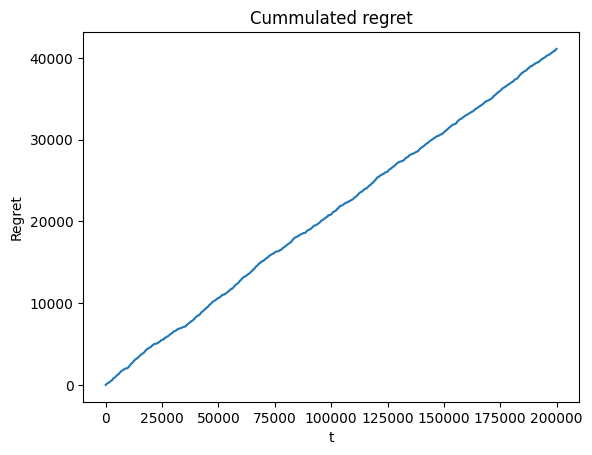

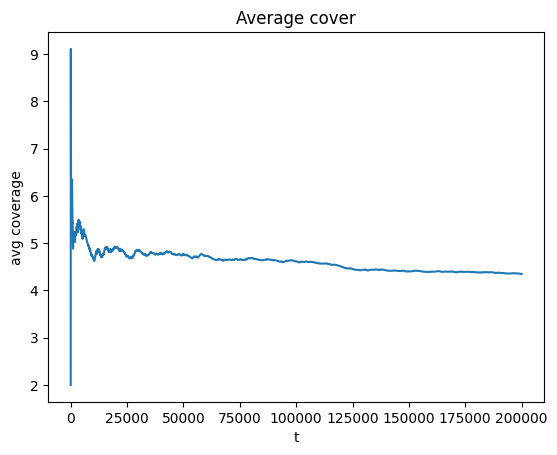

In [42]:
# Simulation
T = 200_000
L = 10

bandit = DC3MABLike(
    n_users=n_users,
    item_factors=item_factors,
    item_cluster=item_cluster,
    cluster_items=cluster_items,
    alpha=0.6,
    lam=1.0,
    edge_init="kmeans",
    user_init_clusters=30,
    split_beta=1.2,
    seed=0
)

regret = np.zeros(T, dtype=float)
coverage = np.zeros(T, dtype=float) # check if the algorithms propose enough seen films to the user

for t in range(T):
    if t % 1000 == 0:
        print(t)
    u, true_item, r = events[t]
    u = int(u); true_item = int(true_item); r = float(r)

    recs = bandit.recommend(u, L=L, per_cluster=2, candidate_clusters=10)

    reg_t, cov_t = regret_custom(u, recs, rating_dict)
    regret[t] = reg_t
    coverage[t] = cov_t

    bandit.update(u, true_item, r)

############################
# Remove to have the average regret on a small window
# avg_regret = np.cumsum(regret) / (np.arange(T) + 1)
# avg_coverage = np.cumsum(coverage) / (np.arange(T) + 1)

# print(f"Final average regret: {avg_regret[-1]:.4f}")
# print(f"Average coverage: {avg_coverage[-1]:.2f} / {L}")
############################

cum_regret = np.cumsum(regret)
avg_coverage = np.cumsum(coverage) / (np.arange(T) + 1)

print(f"Final cummulated regret: {cum_regret[-1]:.2f}")
print(f"Average cover: {avg_coverage[-1]:.2f} / {L}")

plt.figure()
plt.plot(cum_regret)
plt.title("Cummulated regret")
plt.xlabel("t")
plt.ylabel("Regret")
plt.show()

plt.figure()
plt.plot(avg_coverage)
plt.title("Average cover")
plt.xlabel("t")
plt.ylabel("avg coverage")
plt.show()
